In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', 50)
import re
import timeit
import random
random.seed(3)

In [2]:
start = timeit.default_timer()
train = pd.read_csv('train_indessa.csv')
test = pd.read_csv('test_indessa.csv')
stop = timeit.default_timer()
print(stop - start)

6.316136564463026


In [3]:
target = train.loan_status.values
train.drop('loan_status', axis = 1, inplace = True)

In [4]:
size_train = train.shape[0]
size_test = test.shape[0]
full_df = train.append(test)

In [5]:
n = full_df.isnull().sum(axis=1)
full_df['nulls'] = n

In [6]:
drop_cols = ['emp_title','mths_since_last_major_derog', 'batch_enrolled', 'member_id', 'mths_since_last_record']
full_df.drop(drop_cols, axis = 1, inplace = True)

#### Clean Title

In [7]:
def clean_title(raw):
    if ('debt' in raw) or ('consol' in raw) or ('lidation' in raw):
        return 'debt consolidation'
    elif ('credit' in raw) or ('card' in raw):
        return 'credit card'
    elif 'wedd' in raw or 'marr' in raw:
        return 'wedding'
    elif 'home' in raw or 'house' in raw or 'bath' in raw:
        return 'home'
    elif ('car' in raw) or ('motor' in raw) or ('truck' in raw) or ('auto') in raw:
        return 'vehicle'
    elif ('payoff' in raw) or ('off' in raw) :
        return 'payoff'
    elif 'freedom' in raw:
        return 'freedom'
    elif 'pool' in raw:
        return 'pool'
    elif 'persona' in raw :
        return 'personal'
    elif 'vacation' in raw:
        return 'vacation'
    elif 'hosp' in raw or 'med' in raw:
        return 'medical'
    elif 'loan' in raw:
        return 'some loan'
    elif 'movin' in raw:
        return 'moving'
    else :
        return raw

full_df['title'] = full_df.title.apply(lambda x : x.lower() if type(x) == str else '')
full_df['title'] = full_df.title.apply(clean_title)

In [9]:
title_list = full_df.title.values

from collections import Counter
wordsDict = Counter(title_list)
wordsDictSorted = wordsDict.most_common()
wordsDictSorted = dict(wordsDictSorted)

title_list = []
for i in wordsDictSorted:
    if wordsDictSorted[i] > 1:
        title_list.append(i)
    else :
        break

In [10]:
def final_title(raw):
    if raw in title_list:
        return raw
    else :
        return 'Other 2'
full_df['title'] = full_df.title.apply(final_title)

#### Helping functions to clean different columns

In [11]:
def get_emp_length(raw):
    if raw == 'n/a' :
        return np.nan
    elif '+' in raw :
        return 10
    elif '<' in raw :
        return 1
    else :
        return int(re.sub("\D", "", raw))
    
def get_last_week_pay(raw) :
    try :
        return int(re.sub("\D", "", raw))
    except :
        return -9999
    
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
def clean_text(raw_text):
    cleantext = np.nan
    if type(raw_text) == str :
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', raw_text)
        cleantext = cleantext.replace('>', '')
        cleantext = ' '.join(cleantext.split())
        
        stop_words = set(stopwords.words("english"))
        words = word_tokenize(cleantext)
        
        filtered_sentence = []

        for w in words:
            if w not in stop_words:
                filtered_sentence.append(w)
        return len(filtered_sentence)
    
    else :
        return 0 

def verification_status_joint(raw):
    if type(raw) == str:
        return 1
    else :
        return -9999

In [12]:
full_df['term'] = full_df['term'].apply(lambda x : int(re.sub("\D", "", x)))
full_df['emp_length'] = full_df['emp_length'].apply(get_emp_length)
full_df['last_week_pay'] = full_df['last_week_pay'].apply(get_last_week_pay)
full_df['desc'] = full_df['desc'].apply(clean_text)
full_df['verification_status_joint'] = full_df['verification_status_joint'].apply(verification_status_joint)

In [13]:
cols_list = full_df.columns
cols_obj = []
obj_list = full_df.dtypes.values
for col, obj in zip(cols_list, obj_list):
    if obj == object:
        cols_obj.append(col)
        
#full_df[cols_obj].count()

grade                  887379
sub_grade              887379
home_ownership         887379
verification_status    887379
pymnt_plan             887379
purpose                887379
title                  887379
zip_code               887379
addr_state             887379
initial_list_status    887379
application_type       887379
dtype: int64

In [14]:
le = preprocessing.LabelEncoder()
for col in cols_obj:
    full_df[col] = le.fit_transform(full_df[col])

In [16]:
def fill_nulls(value):
    cols_fill = ['emp_length', 'annual_inc','delinq_2yrs', 'inq_last_6mths', 
            'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util',
            'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
            'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
    
    if value == -9999:
        for col in cols_fill:
            full_df.loc[full_df[col].isnull(), col] = -9999
    else : 
        for col in cols_fill:
            full_df.loc[full_df[col].isnull(), col] = full_df[col].median()

In [17]:
fill_nulls(-9999)

#### New features

In [18]:
value = -9999

def helping_features(value):
    full_df['Interest'] = full_df['funded_amnt']*full_df['int_rate']*full_df['term']/(100*12)
    if value == -9999:
        full_df['Monthly_income'] = full_df['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)
        full_df['Monthly_debt_repay'] = full_df['Monthly_income'] * full_df['dti']/100
        full_df['Monthly_debt_repay'] = full_df['Monthly_debt_repay'].apply(lambda x : x if x>0 else -9999) 
    else :
        full_df['Monthly_income'] = full_df['annual_inc']/12
        full_df['Monthly_debt_repay'] = full_df['Monthly_income'] * full_df['dti']/100
    

In [19]:
helping_features(-9999)

In [ ]:
full_df.head()

In [21]:
full_df['unpaid_perc'] = (full_df['Interest'] - full_df['total_rec_int'])/full_df['Interest']

In [22]:
full_df['last_to_term'] = full_df['last_week_pay']/(full_df['term']*52/12)

In [23]:
full_df['monthly_int_to_debt_repay'] = full_df['Interest']/full_df['Monthly_debt_repay']/12

In [24]:
full_df['iti'] = full_df['Interest']/full_df['Monthly_income']/12

In [25]:
full_df['dti_and_iti'] = full_df['iti'] + full_df['dti']

In [26]:
full_df['dtc'] = full_df['Monthly_debt_repay']/full_df['total_rev_hi_lim']/12

In [27]:
full_df['itc'] = full_df['Interest']/full_df['total_rev_hi_lim']/(12*12)

In [28]:
cols = []
for col in full_df.columns:
    if col not in ['Interest', 'total_rec_int','Monthly_income', 'Monthly_debt_repay','last_to_term',
                   'dti_and_iti']:
        cols.append(col)

In [30]:
train_new = full_df[:size_train]
test_new = full_df[size_train:]

train_new = train_new[cols]
test_new = test_new[cols]

In [36]:
import xgboost as xgb
param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 0
param['eval_metric'] = "auc"
param['subsample'] = 1
param['colsample_bytree'] = 1
param['seed'] = 3
num_rounds = 5000

In [39]:
kf = KFold(n_splits=2, shuffle=True, random_state=3)

for train_index, test_index in kf.split(train_new):    
    print("Split")
    model = train_xgb(train_new.iloc[train_index].values, target[train_index], train_new.iloc[test_index].values, target[test_index])

Split
[0]	test-auc:0.821569	train-auc:0.828171
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	test-auc:0.841997	train-auc:0.84945
[2]	test-auc:0.846401	train-auc:0.853583
[3]	test-auc:0.863829	train-auc:0.871497
[4]	test-auc:0.866518	train-auc:0.874875
[5]	test-auc:0.874945	train-auc:0.884098
[6]	test-auc:0.876014	train-auc:0.885247
[7]	test-auc:0.877927	train-auc:0.88704
[8]	test-auc:0.883503	train-auc:0.892573
[9]	test-auc:0.885957	train-auc:0.895429
[10]	test-auc:0.89033	train-auc:0.900241
[11]	test-auc:0.893422	train-auc:0.903069
[12]	test-auc:0.893957	train-auc:0.903746
[13]	test-auc:0.896911	train-auc:0.906947
[14]	test-auc:0.902437	train-auc:0.912636
[15]	test-auc:0.909042	train-auc:0.919704
[16]	test-auc:0.912806	train-auc:0.923695
[17]	test-auc:0.913881	train-auc:0.924931
[18]	test-auc:0.915324	train-auc:0.92672
[19]	test-auc:0.916381	train-auc:0.928033
[20]	test-auc:0.917344	tr

In [38]:
def train_xgb(X_train, y_train, X_val, y_val):
    
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-9999)
    
    dtest = xgb.DMatrix(X_val, label=y_val, missing=-9999)
    
    watchlist  = [(dtest,'test'), (dtrain,'train')]
    bst = xgb.train(param, dtrain, num_rounds, watchlist, early_stopping_rounds=20)
    
    return bst
    #print(get_log_loss(y_val, pred), get_log_loss(y_train, predtrain))

In [397]:
def ceate_feature_map(features):
    outfile = open('xgb_new.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

def xgb_feature_importance(features, model):
    ceate_feature_map(features)
    
    import operator
    importance = model.get_fscore(fmap='xgb_new.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))
    
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    plt.figure()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.show()
    
    return df

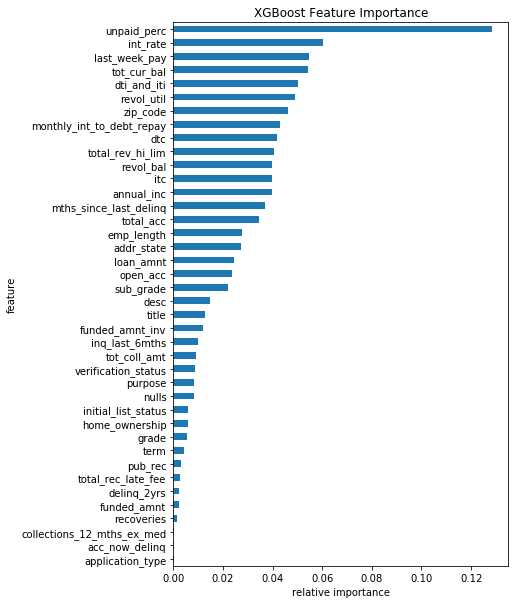

In [463]:
featuredf = xgb_feature_importance(test_new.columns, model)

In [ ]:
def predict_xgb(X_train, y_train, X_test):
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-9999)
    
    dtest = xgb.DMatrix(X_test, missing=-9999)
    
    bst = xgb.train(param, dtrain, num_rounds, early_stopping_rounds = 20)
    
    pred = bst.predict(dtest)
    
    return pred

In [44]:
def train_and_predict(X_train, y_train, X_val, y_val, X_test):
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-9999)
    dtest = xgb.DMatrix(X_val, label=y_val, missing=-9999)
    watchlist  = [(dtest,'test'), (dtrain,'train')]
    bst = xgb.train(param, dtrain, num_rounds, watchlist, early_stopping_rounds=20)
    
    bst.save_model('mymodel')
    bst = xgb.Booster(param)
    bst.load_model('mymodel')
    
    #xgboost issue : https://github.com/dmlc/xgboost/issues/1238
    
    dpredict = xgb.DMatrix(X_test, missing=-9999)
    pred = bst.predict(dpredict)
    return pred

In [72]:
import xgboost as xgb
param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.03
param['max_depth'] = 10
param['silent'] = 0
param['eval_metric'] = "auc"
param['subsample'] = 1
param['colsample_bytree'] = 1
param['seed'] = 3
num_rounds = 5000

In [73]:
### Final predict
kf = KFold(n_splits=5, shuffle=True, random_state=3)
pred_arr = []

for train_index, test_index in kf.split(train_new):    
    print("Split")
    pred_temp = train_and_predict(train_new.iloc[train_index].values, target[train_index], train_new.iloc[test_index].values, target[test_index], test_new)
    print(pred_temp[1:15])
    pred_arr.append(pred_temp)

Split
[0]	test-auc:0.819846	train-auc:0.826761
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	test-auc:0.824011	train-auc:0.831036
[2]	test-auc:0.839138	train-auc:0.846263
[3]	test-auc:0.840771	train-auc:0.848151
[4]	test-auc:0.845082	train-auc:0.852787
[5]	test-auc:0.848148	train-auc:0.855577
[6]	test-auc:0.850239	train-auc:0.857964
[7]	test-auc:0.85145	train-auc:0.859045
[8]	test-auc:0.852528	train-auc:0.860205
[9]	test-auc:0.854591	train-auc:0.862369
[10]	test-auc:0.864048	train-auc:0.871291
[11]	test-auc:0.863929	train-auc:0.871387
[12]	test-auc:0.86937	train-auc:0.876874
[13]	test-auc:0.872662	train-auc:0.880045
[14]	test-auc:0.8746	train-auc:0.881862
[15]	test-auc:0.876186	train-auc:0.883654
[16]	test-auc:0.876818	train-auc:0.884356
[17]	test-auc:0.876835	train-auc:0.884455
[18]	test-auc:0.877447	train-auc:0.885106
[19]	test-auc:0.878523	train-auc:0.886191
[20]	test-auc:0.878706	tr

In [77]:
pred1 = pred_arr[0]
pred2 = pred_arr[1]
pred3 = pred_arr[2]
pred4 = pred_arr[3]
pred5 = pred_arr[4]

In [79]:
pred_avg = (pred1+pred2+pred3+pred4+pred5)/5

[ 0.01939872  0.00611674  0.00093048  0.00824016]
[ 0.08637294  0.0039923   0.00109284  0.00355806]
[ 0.01921678  0.00542966  0.00122057  0.0045633 ]
[ 0.04314448  0.00963231  0.00253062  0.00272677]
[ 0.01974219  0.0062605   0.00123459  0.00552442]


In [81]:
pred_avg = (pred1+pred2+pred3+pred4+pred5)/5
print(pred_avg[1:5])

[ 0.03757502  0.0062863   0.00140182  0.00492254]


In [91]:
test = pd.read_csv('test_indessa.csv')
member_id = test.member_id

In [92]:
ans = pd.DataFrame({
    'member_id' : member_id,
    'loan_status' : pred_avg
})
ans = ans[['member_id','loan_status']]

In [93]:
ans.to_csv('answer_f_5000_rounds_eta_03_1.csv', index = False) ### 0.97892 on lb and (0.97927 after ensemble with prev models)